# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 508 kB 19.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 20.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 28.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 328 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp22 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 16 23:43:25 +0000 2020'
'Mon Nov 16 23:43:14 +0000 2020'
'Mon Nov 16 23:42:54 +0000 2020'
'Mon Nov 16 23:42:53 +0000 2020'
'Mon Nov 16 23:42:40 +0000 2020'
'Mon Nov 16 23:42:32 +0000 2020'
'Mon Nov 16 23:42:10 +0000 2020'
'Mon Nov 16 23:42:01 +0000 2020'
'Mon Nov 16 23:42:00 +0000 2020'
'Mon Nov 16 23:41:49 +0000 2020'
'Mon Nov 16 23:41:46 +0000 2020'
'Mon Nov 16 23:41:46 +0000 2020'
'Mon Nov 16 23:41:42 +0000 2020'
'Mon Nov 16 23:41:40 +0000 2020'
'Mon Nov 16 23:41:28 +0000 2020'
'Mon Nov 16 23:41:27 +0000 2020'
'Mon Nov 16 23:41:22 +0000 2020'
'Mon Nov 16 23:41:16 +0000 2020'
'Mon Nov 16 23:41:00 +0000 2020'
'Mon Nov 16 23:40:58 +0000 2020'
'Mon Nov 16 23:40:56 +0000 2020'
'Mon Nov 16 23:40:47 +0000 2020'
'Mon Nov 16 23:40:46 +0000 2020'
'Mon Nov 16 23:40:44 +0000 2020'
'Mon Nov 16 23:40:38 +0000 2020'
'Mon Nov 16 23:40:37 +0000 2020'
'Mon Nov 16 23:40:35 +0000 2020'
'Mon Nov 16 23:40:28 +0000 2020'
'Mon Nov 16 23:40:23 +0000 2020'
'Mon Nov 16 23:40:18 +0000 2020'
'Mon Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 16 23:34:24 +0000 2020'
'Mon Nov 16 23:34:20 +0000 2020'
'Mon Nov 16 23:34:20 +0000 2020'
'Mon Nov 16 23:34:18 +0000 2020'
'Mon Nov 16 23:34:14 +0000 2020'
'Mon Nov 16 23:34:10 +0000 2020'
'Mon Nov 16 23:34:04 +0000 2020'
'Mon Nov 16 23:34:01 +0000 2020'
'Mon Nov 16 23:33:59 +0000 2020'
'Mon Nov 16 23:33:59 +0000 2020'
'Mon Nov 16 23:33:43 +0000 2020'
'Mon Nov 16 23:33:43 +0000 2020'
'Mon Nov 16 23:33:40 +0000 2020'
'Mon Nov 16 23:33:32 +0000 2020'
'Mon Nov 16 23:33:30 +0000 2020'
'Mon Nov 16 23:33:28 +0000 2020'
'Mon Nov 16 23:33:26 +0000 2020'
'Mon Nov 16 23:33:19 +0000 2020'
'Mon Nov 16 23:33:03 +0000 2020'
'Mon Nov 16 23:33:01 +0000 2020'
'Mon Nov 16 23:32:59 +0000 2020'
'Mon Nov 16 23:32:59 +0000 2020'
'Mon Nov 16 23:32:58 +0000 2020'
'Mon Nov 16 23:32:56 +0000 2020'
'Mon Nov 16 23:32:50 +0000 2020'
'Mon Nov 16 23:32:47 +0000 2020'
'Mon Nov 16 23:32:29 +0000 2020'
'Mon Nov 16 23:32:28 +0000 2020'
'Mon Nov 16 23:32:26 +0000 2020'
'Mon Nov 16 23:32:21 +0000 2020'
'Mon Nov 1

'Mon Nov 16 23:08:45 +0000 2020'
'Mon Nov 16 23:08:43 +0000 2020'
'Mon Nov 16 23:08:40 +0000 2020'
'Mon Nov 16 23:08:33 +0000 2020'
'Mon Nov 16 23:08:30 +0000 2020'
'Mon Nov 16 23:08:21 +0000 2020'
'Mon Nov 16 23:08:13 +0000 2020'
'Mon Nov 16 23:08:13 +0000 2020'
'Mon Nov 16 23:08:09 +0000 2020'
'Mon Nov 16 23:07:59 +0000 2020'
'Mon Nov 16 23:07:55 +0000 2020'
'Mon Nov 16 23:07:53 +0000 2020'
'Mon Nov 16 23:07:42 +0000 2020'
'Mon Nov 16 23:07:38 +0000 2020'
'Mon Nov 16 23:07:32 +0000 2020'
'Mon Nov 16 23:07:03 +0000 2020'
'Mon Nov 16 23:06:51 +0000 2020'
'Mon Nov 16 23:06:48 +0000 2020'
'Mon Nov 16 23:06:48 +0000 2020'
'Mon Nov 16 23:06:46 +0000 2020'
'Mon Nov 16 23:06:29 +0000 2020'
'Mon Nov 16 23:06:17 +0000 2020'
'Mon Nov 16 23:06:13 +0000 2020'
'Mon Nov 16 23:06:10 +0000 2020'
'Mon Nov 16 23:06:09 +0000 2020'
'Mon Nov 16 23:05:53 +0000 2020'
'Mon Nov 16 23:05:50 +0000 2020'
'Mon Nov 16 23:05:29 +0000 2020'
'Mon Nov 16 23:05:25 +0000 2020'
'Mon Nov 16 23:05:19 +0000 2020'
'Mon Nov 1

'Mon Nov 16 22:48:31 +0000 2020'
'Mon Nov 16 22:48:29 +0000 2020'
'Mon Nov 16 22:48:26 +0000 2020'
'Mon Nov 16 22:48:26 +0000 2020'
'Mon Nov 16 22:48:25 +0000 2020'
'Mon Nov 16 22:48:22 +0000 2020'
'Mon Nov 16 22:48:22 +0000 2020'
'Mon Nov 16 22:48:18 +0000 2020'
'Mon Nov 16 22:48:15 +0000 2020'
'Mon Nov 16 22:48:10 +0000 2020'
'Mon Nov 16 22:48:09 +0000 2020'
'Mon Nov 16 22:48:05 +0000 2020'
'Mon Nov 16 22:48:01 +0000 2020'
'Mon Nov 16 22:47:54 +0000 2020'
'Mon Nov 16 22:47:52 +0000 2020'
'Mon Nov 16 22:47:46 +0000 2020'
'Mon Nov 16 22:47:46 +0000 2020'
'Mon Nov 16 22:47:34 +0000 2020'
'Mon Nov 16 22:47:25 +0000 2020'
'Mon Nov 16 22:47:19 +0000 2020'
'Mon Nov 16 22:47:18 +0000 2020'
'Mon Nov 16 22:47:14 +0000 2020'
'Mon Nov 16 22:47:14 +0000 2020'
'Mon Nov 16 22:47:10 +0000 2020'
'Mon Nov 16 22:47:08 +0000 2020'
'Mon Nov 16 22:47:05 +0000 2020'
'Mon Nov 16 22:47:03 +0000 2020'
'Mon Nov 16 22:46:57 +0000 2020'
'Mon Nov 16 22:46:55 +0000 2020'
'Mon Nov 16 22:46:46 +0000 2020'
'Mon Nov 1

'Mon Nov 16 22:28:45 +0000 2020'
'Mon Nov 16 22:28:41 +0000 2020'
'Mon Nov 16 22:28:39 +0000 2020'
'Mon Nov 16 22:28:20 +0000 2020'
'Mon Nov 16 22:28:16 +0000 2020'
'Mon Nov 16 22:28:11 +0000 2020'
'Mon Nov 16 22:28:10 +0000 2020'
'Mon Nov 16 22:28:05 +0000 2020'
'Mon Nov 16 22:28:00 +0000 2020'
'Mon Nov 16 22:27:53 +0000 2020'
'Mon Nov 16 22:27:50 +0000 2020'
'Mon Nov 16 22:27:47 +0000 2020'
'Mon Nov 16 22:27:46 +0000 2020'
'Mon Nov 16 22:27:46 +0000 2020'
'Mon Nov 16 22:27:45 +0000 2020'
'Mon Nov 16 22:27:43 +0000 2020'
'Mon Nov 16 22:27:40 +0000 2020'
'Mon Nov 16 22:27:31 +0000 2020'
'Mon Nov 16 22:27:28 +0000 2020'
'Mon Nov 16 22:27:21 +0000 2020'
'Mon Nov 16 22:27:19 +0000 2020'
'Mon Nov 16 22:27:18 +0000 2020'
'Mon Nov 16 22:27:16 +0000 2020'
'Mon Nov 16 22:27:16 +0000 2020'
'Mon Nov 16 22:27:11 +0000 2020'
'Mon Nov 16 22:27:05 +0000 2020'
'Mon Nov 16 22:27:01 +0000 2020'
'Mon Nov 16 22:27:00 +0000 2020'
'Mon Nov 16 22:26:58 +0000 2020'
'Mon Nov 16 22:26:57 +0000 2020'
'Mon Nov 1

'Mon Nov 16 22:11:53 +0000 2020'
'Mon Nov 16 22:11:44 +0000 2020'
'Mon Nov 16 22:11:43 +0000 2020'
'Mon Nov 16 22:11:35 +0000 2020'
'Mon Nov 16 22:11:32 +0000 2020'
'Mon Nov 16 22:11:31 +0000 2020'
'Mon Nov 16 22:11:30 +0000 2020'
'Mon Nov 16 22:11:27 +0000 2020'
'Mon Nov 16 22:11:26 +0000 2020'
'Mon Nov 16 22:11:25 +0000 2020'
'Mon Nov 16 22:11:23 +0000 2020'
'Mon Nov 16 22:11:19 +0000 2020'
'Mon Nov 16 22:11:18 +0000 2020'
'Mon Nov 16 22:11:12 +0000 2020'
'Mon Nov 16 22:11:12 +0000 2020'
'Mon Nov 16 22:11:04 +0000 2020'
'Mon Nov 16 22:10:59 +0000 2020'
'Mon Nov 16 22:10:54 +0000 2020'
'Mon Nov 16 22:10:53 +0000 2020'
'Mon Nov 16 22:10:51 +0000 2020'
'Mon Nov 16 22:10:50 +0000 2020'
'Mon Nov 16 22:10:50 +0000 2020'
'Mon Nov 16 22:10:49 +0000 2020'
'Mon Nov 16 22:10:43 +0000 2020'
'Mon Nov 16 22:10:43 +0000 2020'
'Mon Nov 16 22:10:43 +0000 2020'
'Mon Nov 16 22:10:40 +0000 2020'
'Mon Nov 16 22:10:37 +0000 2020'
'Mon Nov 16 22:10:33 +0000 2020'
'Mon Nov 16 22:10:27 +0000 2020'
'Mon Nov 1

'Mon Nov 16 21:59:38 +0000 2020'
'Mon Nov 16 21:59:38 +0000 2020'
'Mon Nov 16 21:59:37 +0000 2020'
'Mon Nov 16 21:59:32 +0000 2020'
'Mon Nov 16 21:59:29 +0000 2020'
'Mon Nov 16 21:59:25 +0000 2020'
'Mon Nov 16 21:59:25 +0000 2020'
'Mon Nov 16 21:59:25 +0000 2020'
'Mon Nov 16 21:59:20 +0000 2020'
'Mon Nov 16 21:59:20 +0000 2020'
'Mon Nov 16 21:59:18 +0000 2020'
'Mon Nov 16 21:59:18 +0000 2020'
'Mon Nov 16 21:59:18 +0000 2020'
'Mon Nov 16 21:59:14 +0000 2020'
'Mon Nov 16 21:59:12 +0000 2020'
'Mon Nov 16 21:59:07 +0000 2020'
'Mon Nov 16 21:59:02 +0000 2020'
'Mon Nov 16 21:59:00 +0000 2020'
'Mon Nov 16 21:59:00 +0000 2020'
'Mon Nov 16 21:58:58 +0000 2020'
'Mon Nov 16 21:58:58 +0000 2020'
'Mon Nov 16 21:58:56 +0000 2020'
'Mon Nov 16 21:58:55 +0000 2020'
'Mon Nov 16 21:58:52 +0000 2020'
'Mon Nov 16 21:58:50 +0000 2020'
'Mon Nov 16 21:58:47 +0000 2020'
'Mon Nov 16 21:58:39 +0000 2020'
'Mon Nov 16 21:58:36 +0000 2020'
'Mon Nov 16 21:58:26 +0000 2020'
'Mon Nov 16 21:58:20 +0000 2020'
'Mon Nov 1

'Mon Nov 16 21:49:25 +0000 2020'
'Mon Nov 16 21:49:23 +0000 2020'
'Mon Nov 16 21:49:22 +0000 2020'
'Mon Nov 16 21:49:21 +0000 2020'
'Mon Nov 16 21:49:20 +0000 2020'
'Mon Nov 16 21:49:20 +0000 2020'
'Mon Nov 16 21:49:17 +0000 2020'
'Mon Nov 16 21:49:13 +0000 2020'
'Mon Nov 16 21:49:12 +0000 2020'
'Mon Nov 16 21:49:08 +0000 2020'
'Mon Nov 16 21:49:01 +0000 2020'
'Mon Nov 16 21:48:58 +0000 2020'
'Mon Nov 16 21:48:50 +0000 2020'
'Mon Nov 16 21:48:50 +0000 2020'
'Mon Nov 16 21:48:46 +0000 2020'
'Mon Nov 16 21:48:43 +0000 2020'
'Mon Nov 16 21:48:42 +0000 2020'
'Mon Nov 16 21:48:38 +0000 2020'
'Mon Nov 16 21:48:38 +0000 2020'
'Mon Nov 16 21:48:32 +0000 2020'
'Mon Nov 16 21:48:29 +0000 2020'
'Mon Nov 16 21:48:25 +0000 2020'
'Mon Nov 16 21:48:24 +0000 2020'
'Mon Nov 16 21:48:24 +0000 2020'
'Mon Nov 16 21:48:17 +0000 2020'
'Mon Nov 16 21:48:15 +0000 2020'
'Mon Nov 16 21:48:15 +0000 2020'
'Mon Nov 16 21:48:14 +0000 2020'
'Mon Nov 16 21:48:14 +0000 2020'
'Mon Nov 16 21:48:13 +0000 2020'
'Mon Nov 1

'Mon Nov 16 21:39:32 +0000 2020'
'Mon Nov 16 21:39:31 +0000 2020'
'Mon Nov 16 21:39:31 +0000 2020'
'Mon Nov 16 21:39:27 +0000 2020'
'Mon Nov 16 21:39:26 +0000 2020'
'Mon Nov 16 21:39:24 +0000 2020'
'Mon Nov 16 21:39:23 +0000 2020'
'Mon Nov 16 21:39:23 +0000 2020'
'Mon Nov 16 21:39:21 +0000 2020'
'Mon Nov 16 21:39:20 +0000 2020'
'Mon Nov 16 21:39:19 +0000 2020'
'Mon Nov 16 21:39:12 +0000 2020'
'Mon Nov 16 21:39:12 +0000 2020'
'Mon Nov 16 21:39:11 +0000 2020'
'Mon Nov 16 21:39:05 +0000 2020'
'Mon Nov 16 21:39:05 +0000 2020'
'Mon Nov 16 21:39:05 +0000 2020'
'Mon Nov 16 21:39:04 +0000 2020'
'Mon Nov 16 21:39:03 +0000 2020'
'Mon Nov 16 21:39:01 +0000 2020'


KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1980
1731


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Bara Vaida
text: Interested in learning latest on the flu season and #COVID19? and where we are with #COVID19 vaccines? Check out… https://t.co/P8qyF20ATW
----
name: KP 🇺🇸🙌🏿💙🙌🏻🇺🇸
text: 🟪 #COVID19 ALERT
Southern California is back to Purple Tier 1:
Widespread Risk of Spreading #COVID19 
Restaurants,… https://t.co/AokZTTlfgS
----
name: Sally Deal 🇺🇸 Pro-Science/Media Sources Matter
text: RT @Fam4Fun: 🟪 #COVID19 ALERT
Southern California is back to Purple Tier 1:
Widespread Risk of Spreading #COVID19 
Restaurants, churches, g…
----
name: expobear
text: RT @Fam4Fun: 🟪 #COVID19 ALERT
Southern California is back to Purple Tier 1:
Widespread Risk of Spreading #COVID19 
Restaurants, churches, g…
----
name: Michelle 🌵🍹
text: RT @Fam4Fun: 🟪 #COVID19 ALERT
Southern California is back to Purple Tier 1:
Widespread Risk of Spreading #COVID19 
Restaurants, churches, g…
----
name: 𝓫𝓻𝓮 ☼
text: if self loathing a symptom of covid19
----
name: Erin Snider🆘️ 🇺🇸 🦋🌍🌊
text: @RCampbellmc58 Sorry. 😒

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive,retweeted_status,extended_entities
0,5fb30eb1471850f3db00bed7,Mon Nov 16 22:22:34 +0000 2020,1328463498590949392,1328463498590949392,Interested in learning latest on the flu seaso...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,5fb30ea9471850f3db00bbce,Mon Nov 16 23:23:12 +0000 2020,1328478757653417986,1328478757653417986,🟪 #COVID19 ALERT\nSouthern California is back ...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,2,False,False,en,1.328459e+18,1328458787196448770,{'created_at': 'Mon Nov 16 22:03:51 +0000 2020...,False,NaN,NaN
2,5fb30ea9471850f3db00bbaf,Mon Nov 16 23:26:11 +0000 2020,1328479510367387648,1328479510367387648,RT @Fam4Fun: 🟪 #COVID19 ALERT\nSouthern Califo...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,1.328459e+18,1328458787196448770,NaN,NaN,{'created_at': 'Mon Nov 16 23:23:12 +0000 2020...,NaN
3,5fb30ea9471850f3db00bba1,Mon Nov 16 23:28:33 +0000 2020,1328480102288506881,1328480102288506881,RT @Fam4Fun: 🟪 #COVID19 ALERT\nSouthern Califo...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,1.328459e+18,1328458787196448770,NaN,NaN,{'created_at': 'Mon Nov 16 23:23:12 +0000 2020...,NaN
4,5fb30ea9471850f3db00bb9e,Mon Nov 16 23:29:28 +0000 2020,1328480336360050688,1328480336360050688,RT @Fam4Fun: 🟪 #COVID19 ALERT\nSouthern Califo...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,1.328459e+18,1328458787196448770,NaN,NaN,{'created_at': 'Mon Nov 16 23:23:12 +0000 2020...,NaN
5,5fb30eaa471850f3db00bc2b,Mon Nov 16 23:14:00 +0000 2020,1328476443613954054,1328476443613954054,if self loathing a symptom of covid19,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
6,5fb30eb1471850f3db00be90,Mon Nov 16 22:27:00 +0000 2020,1328464615647309826,1328464615647309826,@RCampbellmc58 Sorry. 😒. #COVID19 reality. 🥀,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.328438e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
7,5fb30eb0471850f3db00be2c,Mon Nov 16 22:34:19 +0000 2020,1328466456569327617,1328466456569327617,Trump is deliberately spreading #covid19. Tha...,False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,4,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
8,5fb30eb6471850f3db00c08a,Mon Nov 16 21:59:57 +0000 2020,1328457805905289216,1328457805905289216,#Covid_19 #covid19 #California https://t.co/lr...,False,"{'hashtags': [{'text': 'Covid_19', 'indices': ...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,und,1.328430e+18,1328430211432665088,{'created_at': 'Mon Nov 16 20:10:18 +0000 2020...,False,NaN,NaN
9,5fb30eb1471850f3db00becd,Mon Nov 16 22:23:09 +0000 2020,1328463644921901056,1328463644921901056,#1u #Labor #COVID19 https://t.co/FGOjus8b06,False,"{'hashtags'

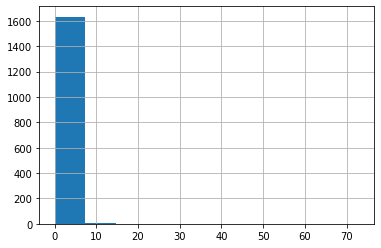

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count